## TRABAJO COMPUTACIONAL 2

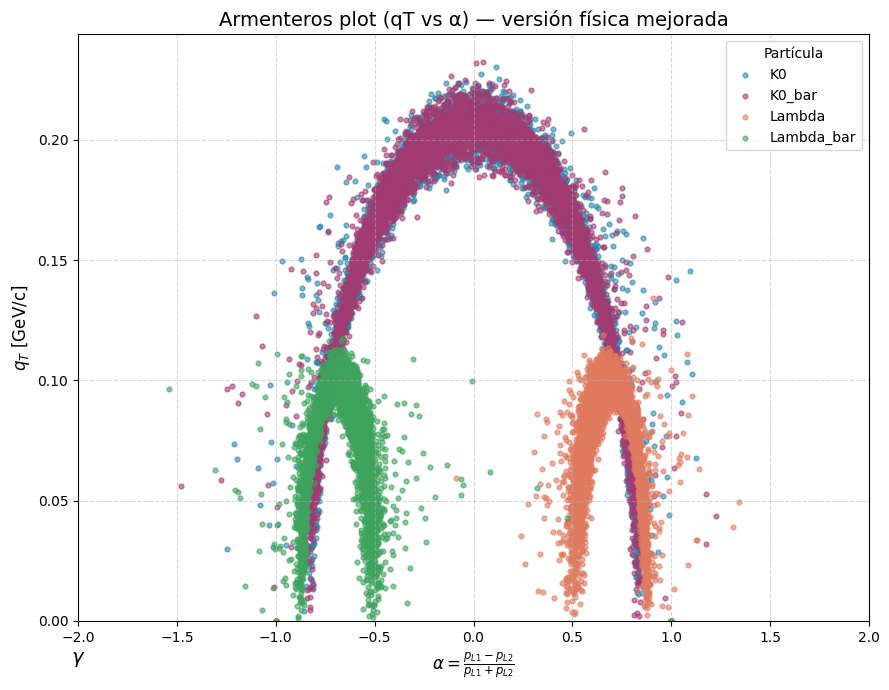


Resumen de simulación (versión con boost aleatorio y smearing en energía):
α min = -1.541, α max = 2.178
qT min = 0.000 MeV, qT max = 232.235 MeV
Eventos totales: 20000
Figura guardada en: results_pdf_v3\armenteros_pdf_v3.png
Simulación completada correctamente.


In [18]:
"""
Simulación Monte Carlo de decaimientos de partículas extrañas:
    K0  → π⁺ π⁻
    Λ0  → p π⁻
y sus antipartículas correspondientes.

Simulación Monte Carlo 2: Decaimientos K0 y Lambada0::
 - Boost relativista en dirección aleatoria.
 - Smearing solo en energía (5%).
 - Cálculo de masa invariante y Armenteros plot.
 - Visualización por proceso con colores y etiquetas.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================
# 1. Constantes físicas (en MeV, usando c = 1)
# ============================================================
m_pi = 139.570
m_p  = 938.272
m_K0 = 497.611
m_L  = 1115.683


# ============================================================
# 2. Funciones auxiliares
# ============================================================

def energy_to_p(E, m):
    """Dada energía total E y masa m, devuelve el módulo del momento p."""
    p2 = E**2 - m**2
    return np.sqrt(np.maximum(p2, 0.0))

def two_body_decay_momenta(M, m1, m2):
    """Cinemática de decaimiento de dos cuerpos en el sistema en reposo."""
    E1 = (M**2 + m1**2 - m2**2) / (2.0*M)
    E2 = (M**2 + m2**2 - m1**2) / (2.0*M)
    p1 = energy_to_p(E1, m1)
    p2 = energy_to_p(E2, m2)
    return E1, p1, E2, p2

def random_direction():
    """Dirección aleatoria isotrópica en 3D (vector unitario y ángulos esféricos)."""
    cos_theta = 2.0*np.random.rand() - 1.0
    theta = np.arccos(cos_theta)
    phi = 2.0*np.pi*np.random.rand()
    ux = np.sin(theta)*np.cos(phi)
    uy = np.sin(theta)*np.sin(phi)
    uz = cos_theta
    return np.array([ux, uy, uz]), theta, phi

def lorentz_boost(p4, beta_vec):
    """
    Aplica un boost de Lorentz general al 4-vector p4 = (E, px, py, pz)
    con velocidad beta_vec (vector 3D, c=1).
    """
    beta = np.linalg.norm(beta_vec)
    if beta == 0:
        return p4.copy()
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    bp = np.dot(beta_vec, p4[1:])
    E_prime = gamma * (p4[0] + bp)
    p_prime = p4[1:] + ((gamma - 1.0) * bp / beta**2 + gamma * p4[0]) * beta_vec
    return np.concatenate(([E_prime], p_prime))


# ============================================================
# 3. Simulación principal (versión física mejorada)
# ============================================================

def simulate_mc_v3(N=20000, seed=42,
                   E_min=600.0, E_max=10000.0,
                   outdir="results_pdf_v3"):
    np.random.seed(seed)
    events = []

    for i in range(N):
        # 1. Selección del proceso
        r = np.random.rand()
        if r < 0.25:
            proc, M, m1, m2 = "K0", m_K0, m_pi, m_pi
        elif r < 0.5:
            proc, M, m1, m2 = "K0_bar", m_K0, m_pi, m_pi
        elif r < 0.75:
            proc, M, m1, m2 = "Lambda", m_L, m_p, m_pi
        else:
            proc, M, m1, m2 = "Lambda_bar", m_L, m_pi, m_p

        # 2. Energía y boost de la madre en el laboratorio (dirección aleatoria)
        E_lab = np.random.uniform(max(M*1.001, E_min), E_max)
        p_lab_mag = energy_to_p(E_lab, M)
        uM, thetaM, phiM = random_direction()
        p_lab_vec = p_lab_mag * uM
        beta_vec = p_lab_vec / E_lab

        # 3. Decaimiento en el marco en reposo de la madre
        E1, p1_mag, E2, p2_mag = two_body_decay_momenta(M, m1, m2)

        # 4. Dirección aleatoria de los productos
        u1, theta1, phi1 = random_direction()
        p1_rest = p1_mag * u1
        p2_rest = -p1_rest

        p4_1_rest = np.array([E1, *p1_rest])
        p4_2_rest = np.array([E2, *p2_rest])

        # 5. Transformación de Lorentz (reposo → laboratorio)
        p4_1_lab = lorentz_boost(p4_1_rest, beta_vec)
        p4_2_lab = lorentz_boost(p4_2_rest, beta_vec)

        # 6. Smearing solo en energía (versión ajustada tipo PDF)
        E1obs = np.random.normal(p4_1_lab[0], 0.05 * p4_1_lab[0])
        E2obs = np.random.normal(p4_2_lab[0], 0.05 * p4_2_lab[0])

        # Mantiene direcciones exactas
        p1_dir = p4_1_lab[1:] / np.linalg.norm(p4_1_lab[1:])
        p2_dir = p4_2_lab[1:] / np.linalg.norm(p4_2_lab[1:])
        p1_mag_obs = np.sqrt(np.maximum(E1obs**2 - m1**2, 0.0))
        p2_mag_obs = np.sqrt(np.maximum(E2obs**2 - m2**2, 0.0))
        p1_obs = p1_mag_obs * p1_dir
        p2_obs = p2_mag_obs * p2_dir

        # 7. Masa invariante reconstruida
        E_tot = E1obs + E2obs
        p_tot = p1_obs + p2_obs
        M_reco = np.sqrt(max(E_tot**2 - np.sum(p_tot**2), 0.0))

        # 8. Variables del Armenteros plot
        p_tot_norm = np.linalg.norm(p_tot)
        if p_tot_norm < 1e-12:
            p_tot_dir = np.array([1.0, 0.0, 0.0])
        else:
            p_tot_dir = p_tot / p_tot_norm

        qT = np.linalg.norm(p1_obs - np.dot(p1_obs, p_tot_dir)*p_tot_dir)
        pL1 = np.dot(p1_obs, p_tot_dir)
        pL2 = np.dot(p2_obs, p_tot_dir)
        alpha = (pL1 - pL2) / (pL1 + pL2 + 1e-12)

        # Guarda el evento
        events.append({
            "proc": proc,
            "M_reco": M_reco,
            "qT": qT,
            "alpha": alpha
        })

    # ------------------------------------------------------------
    # Crear DataFrame y graficar
    # ------------------------------------------------------------
    df = pd.DataFrame(events)

    if not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)

    # Paleta de colores moderna y etiquetas por proceso
    colors = {
        "K0": "#2E86AB",
        "K0_bar": "#A23B72",
        "Lambda": "#E07A5F",
        "Lambda_bar": "#3DA35D"
    }

    plt.figure(figsize=(9,7))
    for proc, color in colors.items():
        mask = df["proc"] == proc
        plt.scatter(df[mask]["alpha"], df[mask]["qT"]/1000,
                    s=12, alpha=0.6, label=proc, color=color)

    plt.title("Armenteros plot (qT vs α) — versión física mejorada", fontsize=14)
    plt.xlabel(r"$\alpha = \frac{p_{L1}-p_{L2}}{p_{L1}+p_{L2}}$", fontsize=12)
    plt.ylabel(r"$q_T$ [GeV/c]", fontsize=12)
    plt.xlim(-2, 2)
    plt.ylim(0, None)
    plt.legend(title="Partícula", fontsize=10)
    plt.text(0, -0.05, r"$\gamma$", ha='center', va='top',
             transform=plt.gca().transAxes, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "armenteros_pdf_v3.png"), dpi=150)

    # Mostrar la figura en consola (útil en Jupyter o VSCode)
    plt.show()

    # ------------------------------------------------------------
    # Mostrar resumen en consola
    # ------------------------------------------------------------
    print("\nResumen de simulación (versión con boost aleatorio y smearing en energía):")
    print(f"α min = {df['alpha'].min():.3f}, α max = {df['alpha'].max():.3f}")
    print(f"qT min = {df['qT'].min():.3f} MeV, qT max = {df['qT'].max():.3f} MeV")
    print(f"Eventos totales: {len(df)}")
    print(f"Figura guardada en: {os.path.join(outdir, 'armenteros_pdf_v3.png')}")

    return df


# ============================================================
# 4. Ejecución directa
# ============================================================
if __name__ == "__main__":
    df = simulate_mc_v3(N=20000, seed=42)
    print("Simulación completada correctamente.")
